# Homework 2

Last Name: Tressel

First Name: Thomas


The goal of this second homework is to replicate some famous results from classical Business Cycle analysis.

As usual, you are allowed to install any library, and encouraged to help each other. Copying/pasting is not allowed though.

The notebook will be evaluated along three dimensions:
- correctness (whether you answered the questions correctly)
- readibility
- originality (there are bonus points if you took some nice initiative)

Homeworks should be handled by midnight on **June 26th**.

## Measuring business cycles moments

__Choose a country. Download data for production, investment, consumption at *quarterly* frequency using dBnomics or any other method.__

In [14]:
import Pkg; Pkg.add("DBnomics"); Pkg.add("DataFrames"); Pkg.add("TimeSeries")

using DBnomics
using DataFrames
using TimeSeries

    Updating registry at `C:\Users\tress\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Manifest.toml`


In [15]:
# A couple functions to transform the datasets given by the DBnomics package into the desired time series form

# Taken from the DBnomics GitHub, since the package itself does not have built-in functions to do this, despite displaying
# these functions to users on the GitHub repo

function to_namedtuples(x::DataFrames.DataFrame)
    nm = names(x)
    vl = try
        [x[!, col] for col in names(x)]
    catch
        [x[:, col] for col in names(x)]
    end
    nm = tuple(Symbol.(nm)...)
    vl = tuple(vl...)

    NamedTuple{nm}(vl)
end

function to_timeseries(
    x::DataFrames.DataFrame,
    index = :period, variable = :series_code, value = :value
)
    x = unstack(x, index, variable, value)
    x = to_namedtuples(x)
    x = TimeArray(x, timestamp = index)
    x
end

to_timeseries (generic function with 4 methods)

In [16]:
# Access the datasets and transform them into TimeArray objects

df_investment = TimeSeries.rename(to_timeseries(rdb(ids = "OECD/QNA/FRA.P51.CQR.Q")), "Investment");

df_consumption = TimeSeries.rename(to_timeseries(rdb(ids = "OECD/QNA/FRA.P31S14.CQR.Q")), "Consumption");

df_production = TimeSeries.rename(to_timeseries(rdb(ids = "OECD/QNA/FRA.B1_GS1.CQR.Q")), "Production");

__Describe the data briefly (source, the spanning period, ...)__

The three datasets are taken from the OECD through DBnomics. They all start in Q1 1980, and contain data for France. I used gross fixed capital formation for investment, GDP for production, and final consumption expenditure of households for consumption. All three datasets are in national currency (franc/euro) and in current prices, and are not seasonally adjusted.

__Detrend the data using the HP filter with the appropriate smoothing parameter $\lambda$. For each series $y_t$ it yields a decomposition between the trend $\tau_t$ and the cycle $c_t$.__

In [17]:
Pkg.add("QuantEcon")

using QuantEcon

   Resolving package versions...
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\tress\.julia\environments\v1.7\Manifest.toml`


In [18]:
# I apply the HP filter to the logarithm of the three variables
# I set λ = 1600, as Hodrick and Prescott suggest

investment_data = [i[2][1] for i in df_investment];
investment_cyclical, investment_trend = QuantEcon.hp_filter(log.(investment_data), 1600);

production_data = [i[2][1] for i in df_production];
production_cyclical, production_trend = QuantEcon.hp_filter(log.(production_data), 1600);

consumption_data = [i[2][1] for i in df_consumption];
consumption_cyclical, consumption_trend = QuantEcon.hp_filter(log.(consumption_data), 1600);

In [19]:
# I create and merge the separate TimeArrays to a single one for each variable

temp1 = TimeArray(getfield(df_investment, :timestamp), investment_cyclical, ["Investment_cyclical"]);
temp2 = TimeArray(getfield(df_investment, :timestamp), investment_trend, ["Investment_trend"]);
df_investment_components = merge(df_investment, temp1, temp2);

temp1 = TimeArray(getfield(df_production, :timestamp), production_cyclical, ["Production_cyclical"]);
temp2 = TimeArray(getfield(df_production, :timestamp), production_trend, ["Production_trend"]);
df_production_components = merge(df_production, temp1, temp2);

temp1 = TimeArray(getfield(df_consumption, :timestamp), consumption_cyclical, ["Consumption_cyclical"]);
temp2 = TimeArray(getfield(df_consumption, :timestamp), consumption_trend, ["Consumption_trend"]);
df_consumption_components = merge(df_consumption, temp1, temp2);

__Plot for each series, the decomposition between trend and cycle.__

In [20]:
using Plots

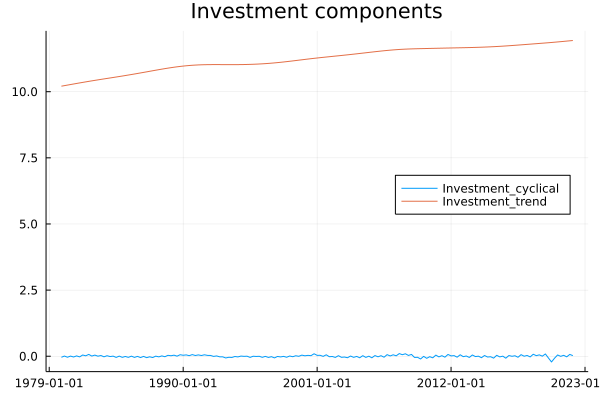

In [21]:
plot(df_investment_components[:Investment_cyclical, :Investment_trend], title = "Investment components", legend = :right)

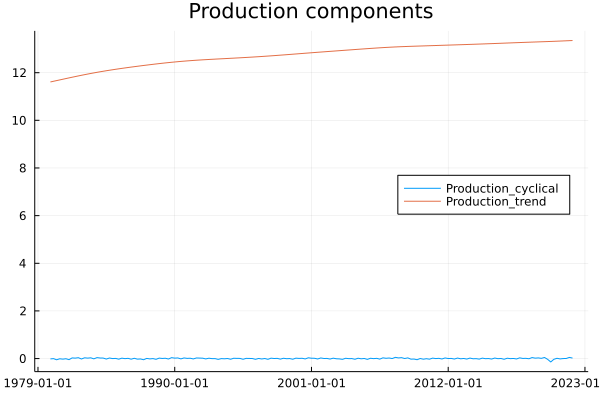

In [22]:
plot(df_production_components[:Production_cyclical, :Production_trend], title = "Production components", legend = :right)

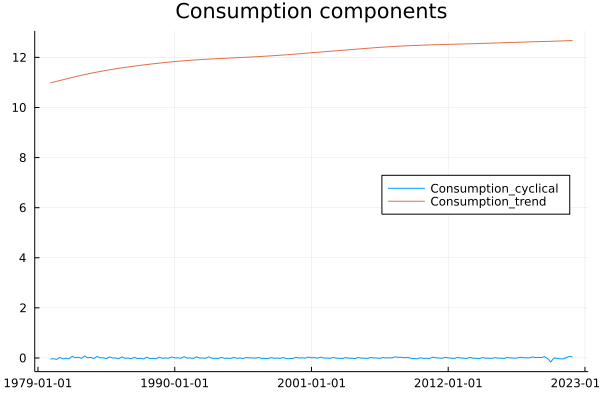

In [23]:
plot(df_consumption_components[:Consumption_cyclical, :Consumption_trend], title = "Consumption components", legend = :right)

__For each series compute the log-deviation from the trend $d_t =log(c_t/ \tau_t)$.__

In [24]:
# As certain cylical components are negative, I take the absolute value
# I then append the log-deviation from the trend to the time series

cyclical = [abs(i[2][2]) for i in df_investment_components];
trend = [abs(i[2][3]) for i in df_investment_components];
deviation = log.(cyclical./trend);
temp = TimeArray(getfield(df_investment_components, :timestamp), deviation, ["log_deviation"]);
df_investment_final = merge(df_investment_components, temp);

cyclical = [abs(i[2][2]) for i in df_production_components];
trend = [abs(i[2][3]) for i in df_production_components];
deviation = log.(cyclical./trend);
temp = TimeArray(getfield(df_production_components, :timestamp), deviation, ["log_deviation"]);
df_production_final = merge(df_production_components, temp);

cyclical = [abs(i[2][2]) for i in df_consumption_components];
trend = [abs(i[2][3]) for i in df_consumption_components];
deviation = log.(cyclical./trend);
temp = TimeArray(getfield(df_consumption_components, :timestamp), deviation, ["log_deviation"]);
df_consumption_final = merge(df_consumption_components, temp);


__Compute standard-deviations and correlations, between all three detrended series (in log deviations). Compute the ratio between the standard deviation of consumption (resp investment) and that of output. These two statistics are the ones that will be compared with the predictions of the model.__

In [25]:
using Statistics

In [26]:
# I calculate the standard deviations of the log deviations of each time series

investment_data = [i[2][4] for i in df_investment_final];
std_investment = std(investment_data);

production_data = [i[2][4] for i in df_production_final];
std_production = std(production_data);

consumption_data = [i[2][4] for i in df_consumption_final];
std_consumption = std(consumption_data);

println("Investment-output standard deviation ratio: ", std_investment / std_production)
println("Consumption-output standard deviation ratio: ", std_consumption / std_production)

Investment-output standard deviation ratio: 0.9633061887647629
Consumption-output standard deviation ratio: 1.0893607462394945


In [27]:
# Here, I find the correlations between the variables

corr_investment_consumption = cor(investment_data, consumption_data)
println("Investment-consumption correlation: ", corr_investment_consumption)

corr_investment_production = cor(investment_data, production_data)
println("Investment-production correlation: ", corr_investment_production)

corr_consumption_production = cor(consumption_data, production_data)
println("Consumption-production correlation: ", corr_consumption_production)

Investment-consumption correlation: 0.3388657052915795
Investment-production correlation: 0.43849541899652095
Consumption-production correlation: 0.4003894642741483

## Solving the RBC model


We consider the RBC model as in the lectures. The representative agent maximizes utility from consumption $c_t$ and labour $l_t$:

$$\max \sum_t \beta^t  \left( \frac{c^{1-\gamma}}{1-\gamma} + \chi \frac{(1-l_t)^{1-\eta}}{1-\eta} \right)$$

The capital is accumulated according to the following law of motion:

$$k_t = (1-\delta) k_{t-1} + i_{t-1}$$

where $\delta$ is the depreciation rate and $i_t$ is the investment.
The productive sector combines labour and capital to produce:

$$y_t = \exp(z_t) k_t^{\alpha} l_t^{1-\alpha}$$

with $z_t = \rho z_{t-1} + \epsilon_t$ being an autoregressive productivity process driven by i.i.d. shock $\epsilon_t$ (with standard deviation $\sigma_\epsilon$).

The budget constraint is 

$$y_t = c_t + i_t$$

__Math: What are the states (s) ? The controls (x) ? The shocks (e) ?__

The two states are productivity $z_t$ and capital $k_t$.

The controls are consumption $c_t \in [0, y_t]$, labor $l_t$ and investment $i_t$.

Finally, the shock is $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon)$.

__Math: Write down the first order conditions for the model (for the social planner version). What are the two transition (g) equations such that $s_t = g(s_{t-1},x_{t-1},e_t)$ ? The two arbitrage (f) equations such that $f(s_t, x_t, s_{t+1}, x_{t+1})=0$ ?__

The two first-order conditions are:
$$
\begin{cases}
    U'(c_t) = \beta \mathbb{E}_t [U'(c_{t+1}) ((1-\delta) + \alpha e^{z_{t+1}} k^{\alpha-1}_{t+1} l^{1-\alpha}_{t+1})] \\
    \chi V'(1 - l_t) = (1 - \alpha) e^{z_t} k^\alpha_t (n_t)^{-\alpha}U'(c_t)
\end{cases}
$$

Where
$$
U(c_t) = \frac{c_t^{1-\gamma}}{1 - \gamma} \quad \text{and} \quad V(l_t) = \frac{(1-l_t)^{1-\eta}}{1-\eta}
$$

The two transition equations are:
$$
\begin{cases}
    z_t = \rho z_{t-1} + \epsilon_t \\
    k_t = (1 - \delta) k_{t-1} + i_{t-1}
\end{cases}
$$

And the two arbitrage equations are:
$$
\begin{cases}
    \beta \left( \frac{c_{t+1}}{c_t} \right)^{- \gamma} \times ( (1-\delta) + \alpha e^{z_{t+1}} k_{t+1}^{\alpha - 1} l^{1-\alpha}_{t+1}) = 1 \\
    c_t + i_t - e^{z_{t+1}} k_{t+1}^{\alpha} l^{1-\alpha}_{t+1}= 0
\end{cases}
$$


__Math: Write down the conditions pinning down the steady-state of the model, given that $\chi$  in order to satisfy: $\overline{l}=\frac{1}{3}$.__

The steady state is such that $k_t = k_{t-1}$ and $c_t = c_{t-1}$.

In the following questions you are expected to take the code from the `neoclassical.ipynb` notebook in order to adapt it to your need. In doing so, feel free to add comments and docstrings to the code.

__Create a structure holding the parameters and the steady-state values of the model. Choose and justify briefly a *quarterly* parameterization.__

To run the code in this second exercise, I need to clear the kernel or else I am faced with errors. I believe there must be some conflict with code in the first exercise, but I cannot determine the source.

In [1]:
using LabelledArrays
using ForwardDiff
using Plots

In [2]:
c = let # calibration
	l = 0.33
	α = 0.3
	β = 0.96
	γ = 4.0
	δ = 0.1
	ρ = 0.9
	k = ((1/β-(1-δ))/α)^(1/(α-1))
	i = δ*k
	c = k^α - i
	z = 0.0
	ϵ = 0.0
	σ_ϵ = 0.016
	p = SLVector((;α, β, γ, δ, ρ)) # parameters
	s = SLVector((;k,z))           # states
	x = SLVector((;c, i))          # controls
	e = SLVector((;ϵ))             # exogenous shock (iid)
	Σ_e = [[σ_ϵ^2]]  # variance/covariance matrix of the shocks
	(;p, s, x, e, Σ_e)
end

(p = 5-element SLArray{Tuple{5}, Float64, 1, 5, (:α, :β, :γ, :δ, :ρ)} with indices SOneTo(5):
 :α => 0.3
 :β => 0.96
 :γ => 4.0
 :δ => 0.1
 :ρ => 0.9, s = 2-element SLArray{Tuple{2}, Float64, 1, 2, (:k, :z)} with indices SOneTo(2):
 :k => 2.920822149964071
 :z => 0.0, x = 2-element SLArray{Tuple{2}, Float64, 1, 2, (:c, :i)} with indices SOneTo(2):
 :c => 1.087194911375516
 :i => 0.29208221499640713, e = 1-element SLArray{Tuple{1}, Float64, 1, 1, (:ϵ,)} with indices SOneTo(1):
 :ϵ => 0.0, Σ_e = [[0.000256]])

We use a quarterly paramerterization in order to uncover the cycles and fluctuations that occur each year, without have overly short (i.e. monthly) time periods.

__Define the transition and arbitrage functions. Check that they are compatible with steady-state values.__

In [3]:
function arbitrage(s,x,S,X,p)
	# upper case for variables tomorrow
	
	# I wasn't able to implement labor into these functions, as during the solving process I would get
	# dimension mismatch errors I didn't know how to solve
	r1 = p.β*(X.c/x.c)^(-p.γ)*( (1-p.δ) + p.α*exp(S.z)*S.k^(p.α-1) ) - 1
	r2 = x.c + x.i - exp(S.z)*S.k^p.α
	SLVector((;r1, r2))
end

function transition(s,x,e,p)
	k = s.k * (1-p.δ) + x.i 
	z = s.z * p.ρ + e.ϵ
	SLVector((;k, z))
end

transition (generic function with 1 method)

In [4]:
println("Initialization: ", c.s)

println("Transition: ", transition(c.s, c.x, c.e, c.p))

Initialization: 2-element SLArray{Tuple{2}, Float64, 1, 2, (:k, :z)} with indices SOneTo(2):
 :k => 2.920822149964071
 :z => 0.0
Transition: 2-element SLArray{Tuple{2}, Float64, 1, 2, (:k, :z)} with indices SOneTo(2):
 :k => 2.920822149964071
 :z => 0.0


As these are the same, we conclude that the functions are indeed compatible with the steady-state values.

__Differentiate all equations to get the first order representation of the model.__

In [5]:
# the object J contains a representation of the first order model
J = let
	(;p, s, x, e, Σ_e) = c
	A = ForwardDiff.jacobian(u->arbitrage(u,x,s,x,p),s)
	B = ForwardDiff.jacobian(u->arbitrage(s,u,s,x,p),x)
	C = ForwardDiff.jacobian(u->arbitrage(s,x,u,x,p),s)
	D = ForwardDiff.jacobian(u->arbitrage(s,x,s,u,p),x)
	E = ForwardDiff.jacobian(u->transition(u,x,e,p), s)
	F = ForwardDiff.jacobian(u->transition(s,u,e,p), x)
	G = ForwardDiff.jacobian(u->transition(s,x,u,p), e)
	(;A,B,C,D,E,F,G)
end

(A = [0.0 0.0; 0.0 0.0], B = [3.679193085018409 0.0; 1.0 1.0], C = [-0.03259356274094644 0.13600000000000004; -0.14166666666666672 -1.379277126371923], D = [-3.679193085018409 -0.0; 0.0 0.0], E = [0.9 0.0; 0.0 0.9], F = [0.0 1.0; 0.0 0.0], G = [0.0; 1.0;;])

__Apply the time-iteration algorithm to find a solution $X$ for the controls. It approximates controls as a function of the states $\Delta x_t = X \Delta s_t$ (where $\Delta$ is the deviation from the steady-state). Check that $X$ satifsfies indeed the first order model.__

In [6]:
function F(X, J)
	(;A, B, C, D, E, F) = J
	return (A+(C+D*X)*E) + (B+(C+D*X)*F)*X
end

distance(A,B) = maximum(abs, (A-B))

function T(X0, J)
	(;A, B, C, D, E, F) = J
	X1 = -(B+(C+D*X0)*F)\(A+(C+D*X0)*E)
end

function solve(J; maxit=1000, τ_η=1e-10, τ_ϵ=1e-8)
	# Finds a solution X for the controls
	
	X0 = randn(typeof(J.B))
	for n=1:maxit
		X1 = T(X0, J)
		η = distance(X0, X1)
		X0 = X1
		if η<τ_η
			break
		end
		
	end
	ϵ = maximum(abs, F(X0, J))
	
	# following matrices are such that:
	# s_t = P s_{t-1} + Q e_t
	P = J.E + J.F*X0
	Q = J.G

	(;X=X0, P=P, Q=Q, converged=ϵ<τ_ϵ)
end

solve (generic function with 1 method)

In [7]:
solution = solve(J);

In [8]:
# We check that the solution to the linear model approaches zero

F(solution.X, J)

2×2 StaticArrays.SMatrix{2, 2, Float64, 4} with indices SOneTo(2)×SOneTo(2):
 8.04462e-12   2.49929e-10
 0.0          -2.22045e-16

__Compute matrices $P$ and $Q$ for the states so that the evolution of states is given by $$\Delta s_t = P \Delta s_{t-1}  + Q e_t$$__

Found above in the `solve` function.

__Check that the model is well defined, that is, that it satisfies the forward and backward stability conditions.__


In [9]:
norm(x::AbstractVector{Float64}) = sqrt(sum(x.^2))/length(x)
norm(x::AbstractMatrix{Float64}) = norm(x[:])

function power_iteration(L, X0; maxit=1000)
	λ = 1
	u0 = rand(typeof(X0))
	u0 = u0/norm(u0)
	for it in 1:maxit
		x1 = L(u0)
		λ = norm(x1)
		u1 = x1/λ
		u0 = u1
	end
	return λ
end

function power_iteration(L::AbstractMatrix; maxit=1000)
	X0 = L[:,1]
	power_iteration(u->L*u, X0)
end

power_iteration (generic function with 2 methods)

In [10]:
λ_B = power_iteration(solution.P)

0.9236623309705777

In [11]:
function Tp(u, J)
	(; A, B, C, D, E, F) = J
	- (B+(C+D*solution.X)*F) \ (D*u*(E+F*solution.X))
end

Tp (generic function with 1 method)

In [12]:
λ_F = power_iteration( u-> Tp(u, J), solution.X)

0.8136543191718936

In [13]:
println("Solution: ", solution.X)
println("Backwards stability: ", λ_B <= 1)
println("λ_B = ", λ_B)
println("Forward stability: ", λ_F <= 1)
println("λ_F = ", λ_F)

Solution: [0.10718983258369104 0.5721253342042864; 0.023662330970457102 0.7796785392587701]
Backwards stability: true
λ_B = 0.9236623309705777
Forward stability: true
λ_F = 0.8136543191718936


We have both forward and backwards stability: the model is indeed well-defined.

__Write a method to make stochastic simulations of the model starting from the steady-state. Your function should use, the calibration structure and the matrices `P` and `Q` defined above. Add an option to compute the series either in deviations to the steady-state or in levels.__

__Compute 200 random draws of the model over a 40 periods horizon. For each draw, perform the same steps as in the first part (hp filter, computation of the correlations). Compare the ratio of volatility investment/output and consumption/output both in the data and in the simulated model. Comment?__